#--------------------------------Random Forest Regressor--------------------------------

# Conecting to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the Necessary Libraries

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Data Loading


In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/ML Project/Bengaluru_House_Data.csv')
dataset.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# Exploratory Data Analysis (EDA)


## Data Cleaning

In [5]:

dataset.drop_duplicates(inplace=True)
dataset.dropna(subset=['total_sqft', 'size', 'price'], inplace=True)  # Ensure essential columns are not null


In [6]:
dataset.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### Transform the 'size' column in the dataset to extract numeric values

In [7]:

dataset['size'] = dataset['size'].apply(lambda x: int(str(x).split(' ')[0]) if isinstance(x, str) else x)


In [8]:
dataset.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2,NaN,1200,2.0,1.0,51.00


# Data Preprocessing

## Convert 'total_sqft' to a numeric value

In [9]:

def convert_sqft_to_num(x):
    if '-' in str(x):
        tokens = x.split('-')
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

dataset['total_sqft'] = dataset['total_sqft'].apply(convert_sqft_to_num)
dataset.dropna(inplace=True)

## Ensure only numeric columns are included for the correlation matrix

In [10]:
numeric_data = dataset.select_dtypes(include=[np.number])


## Correlation Matrix for Numerical Features

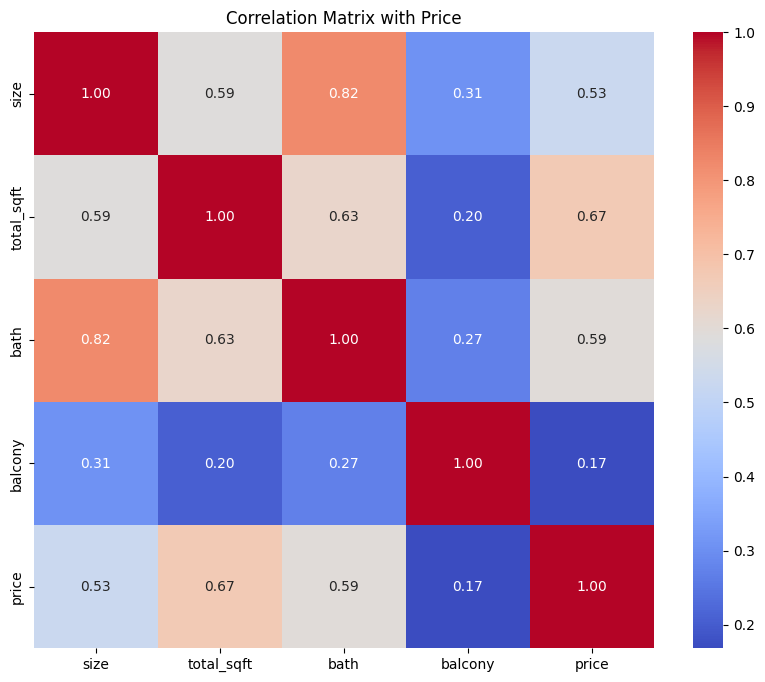

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix with Price")
plt.show()


## Ensure only numeric columns are included for the correlation matrix

In [12]:
numeric_data = dataset.select_dtypes(include=[np.number])

## Calculate the correlation matrix for numerical features

In [13]:
correlation_matrix = numeric_data.corr()

## Identify low-correlation columns with 'price' (threshold < 0.1)

In [14]:
low_correlation_features = correlation_matrix.index[abs(correlation_matrix['price']) < 0.1]

## Drop columns with low correlation to 'price' in the main dataset

In [15]:
dataset = dataset.drop(columns=low_correlation_features)

# Handle categorical Data



## Encode 'location' as a numerical feature for chi-squared test

In [16]:
location_counts = dataset['location'].value_counts()
dataset['location'] = dataset['location'].apply(lambda x: x if location_counts[x] > 10 else 'Other')
label_encoder = LabelEncoder()
dataset['location_encoded'] = label_encoder.fit_transform(dataset['location'])


# Handle categorical features 'area_type', 'availability', 'location', and 'society'
# Encode 'area_type' and 'availability' for chi-squared test


In [17]:
label_encoder = LabelEncoder()
dataset['area_type_encoded'] = label_encoder.fit_transform(dataset['area_type'])
dataset['availability_encoded'] = label_encoder.fit_transform(dataset['availability'])

# Fill NaN values in 'society' and encode it for chi-squared test

In [18]:
dataset['society'] = dataset['society'].fillna('Unknown')  # Assign filled values directly
dataset['society_encoded'] = label_encoder.fit_transform(dataset['society'])

# Convert 'price' to categorical data by binning into price ranges

In [19]:
price_bins = pd.qcut(dataset['price'], q=3, labels=['Low', 'Medium', 'High'])
dataset['price_category'] = price_bins


# Chi-Squared Test

In [20]:
# Chi-Squared Test for 'location' and 'society' against the binned 'price_category'
chi_scores_loc, p_values_loc = chi2(dataset[['location_encoded']], dataset['price_category'].cat.codes)
chi_scores_soc, p_values_soc = chi2(dataset[['society_encoded']], dataset['price_category'].cat.codes)

print(f"Chi-Squared Score for Location: {chi_scores_loc[0]}, P-Value: {p_values_loc[0]}")
print(f"Chi-Squared Score for Society: {chi_scores_soc[0]}, P-Value: {p_values_soc[0]}")

# Chi-Squared Test for 'area_type' and 'availability' against the binned 'price_category'
# Convert 'price' to categorical data for chi-squared testing

chi_scores_area, p_values_area = chi2(dataset[['area_type_encoded']], dataset['price_category'].cat.codes)
chi_scores_avail, p_values_avail = chi2(dataset[['availability_encoded']], dataset['price_category'].cat.codes)

print(f"Chi-Squared Score for Area Type: {chi_scores_area[0]}, P-Value: {p_values_area[0]}")
print(f"Chi-Squared Score for Availability: {chi_scores_avail[0]}, P-Value: {p_values_avail[0]}")


Chi-Squared Score for Location: 556.0604481262152, P-Value: 1.7906383728868622e-121
Chi-Squared Score for Society: 3166.738786217457, P-Value: 0.0
Chi-Squared Score for Area Type: 8.639775290823856, P-Value: 0.013301377929329629
Chi-Squared Score for Availability: 17.6039269945285, P-Value: 0.00015043740148704842


# Decide to keep or remove

In [21]:
# Decide to keep or remove 'location' and 'society' based on chi-squared test results
if p_values_loc[0] >= 0.05:
    dataset = dataset.drop(['location', 'location_encoded'], axis=1)
else:
    dataset = pd.get_dummies(dataset, columns=['location'], drop_first=True)

if p_values_soc[0] >= 0.05:
    dataset = dataset.drop(['society', 'society_encoded'], axis=1)
else:
    dataset = pd.get_dummies(dataset, columns=['society'], drop_first=True)
    # Drop 'area_type' and 'availability' if they have a high p-value (not statistically significant)
if p_values_area[0] >= 0.05:
    dataset = dataset.drop(['area_type', 'area_type_encoded'], axis=1)
else:
    dataset = pd.get_dummies(dataset, columns=['area_type'], drop_first=True)

if p_values_avail[0] >= 0.05:
    dataset = dataset.drop(['availability', 'availability_encoded'], axis=1)
else:
    dataset = pd.get_dummies(dataset, columns=['availability'], drop_first=True)



# Separate features and target variable

In [22]:
X = dataset.drop(['price', 'price_category'], axis=1)
y = dataset['price']

X.head()

,size,total_sqft,bath,balcony,location_encoded,area_type_encoded,availability_encoded,society_encoded,location_5th Phase JP Nagar,location_7th Phase JP Nagar,...,availability_21-May,availability_21-Nov,availability_21-Oct,availability_21-Sep,availability_22-Dec,availability_22-Jan,availability_22-Jun,availability_22-May,availability_22-Nov,availability_Ready To Move
0,2,1056.0,2.0,1.0,44,3,35,441,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,2600.0,5.0,3.0,34,2,73,2351,False,False,...,False,False,False,False,False,False,False,False,False,True
3,3,1521.0,3.0,1.0,99,3,73,2107,False,False,...,False,False,False,False,False,False,False,False,False,True
5,2,1170.0,2.0,1.0,136,3,73,583,False,False,...,False,False,False,False,False,False,False,False,False,True
11,4,2785.0,5.0,3.0,136,2,73,1564,False,False,...,False,False,False,False,False,False,False,False,False,True


# Split data into training and testing sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training with Random Forest

In [24]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Predict on test set

In [25]:
y_pred = model.predict(X_test)

# Evaluate the model

In [26]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 17.399440586541363
Root Mean Squared Error (RMSE): 39.23284126825341


# Plot Actual vs Predicted values

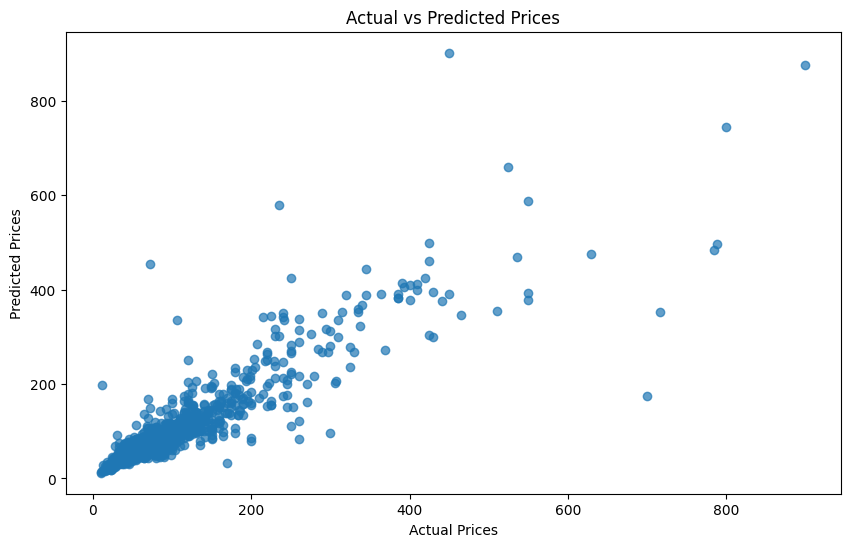

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()